# Using Recurrent Neural Networks for Track Detection In Noise

# Motivation
By observing sonar or radar screens, humans can easily detect tracks, formed by objects that typically are far away and are observed only as points. The respective point patterns can be visually detected even in noisy images. Moreover, in cases when tracks keep appearing and disappearing in noise, trained operators can quickly decide whether unconnected tracks themselves form patterns of tracks that are likely related to the same object.

The above mentioned observations are needed to make a decision about presence or absence of an object. For example, if the object is very bright as compared to noise then such a decision can be made by observing (or detecting) just a single bright point. However, if the points related to noise exhibit brightness comparable to the object of interest, we end up with a number of false detections. As the next step in object detection, we assume that noise is homogeneous and therefore the points related to noise do not form tracks. However, if noise distribution is not homogeneous, points related to noise can form short tracks too. Thus, we end up with false track detections. Such a situation occurs when due to noise, the tracks of the object of interest are short so that they appear and disappear exhibiting noise-track intermittency. In this is a case, human observer would look for the pattern of tracks that can be related to a single object. Once such a pattern of tracks is found, presence of an object of interest can be declared.

On another hand, with the increasing noise level and a number of objects to track, the existing tracking algorithms based on modeling of object motion,  have to deal with the exponentially increasing computational complexity. It should also be noted that carrying out respective calculations increase data processing power consumption along with a need of more powerful processors and the increased memory requirements.

Recent significant progress in various applications of machine learning (e.g. deep learning, DL) have demonstrated the results matching or even exceeding human's  abilities (e.g. in playing chess or go). A success in implementation of trained DLs on small single-board computers such as Raspberry Pi, indicate possible new directions of the DL application to the problems of object detection, tracking, and localization by inexpensive autonomous, low power consuming robots.

# Approach
In this work I will look into a toy problem of track detection of binary (i.e. black and white) images. The respective Python code, written as Jupyter notebook, uses Keras framework and is available here. Below, I show the main blocks of this code, and the output of the calculations.

The problem shown below is not a trivial one, and its success warrants further research in this area. Below I implemented a type of Recurrent Neural Network (RNN), called the long-short-time-memory (LSTM) network. The idea is to apply an algorithm that can use spatial and time information concurrently, such that is able to capture patterns of object exhibiting intermittent appearance and disappearance in noise.

Prior getting to concrete examples, I import all Python modules, required for this work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.font_manager import FontProperties
%matplotlib inline

from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras import optimizers
import utils


Using TensorFlow backend.


Now I load the pre-generated artificial data required for the LSTM training and testing. Note that I have used 3000 and 300 images for training and testing respectively. These images were stacked into 3D matrices, each image having a size of 10 by 30 pixels. Each image was labeled as either noisy (y[i] = 0) or including track (y[i]=1).

In [2]:
DATA_PATH = ''
test_fname_start = 'test_linear'
train_fname_start = 'train_linear'
no_files = 1
train_X, train_y_true = utils.load_data(DATA_PATH, train_fname_start, no_files)
test_X, test_y_true = utils.load_data(DATA_PATH, test_fname_start, no_files)
print(train_X.shape, test_X.shape, train_y_true.shape, test_y_true.shape)

(3000, 10, 30) (300, 10, 30) (3000, 1) (300, 1)


Next, to show the structure of the data, we look into a few example images.


# Examples

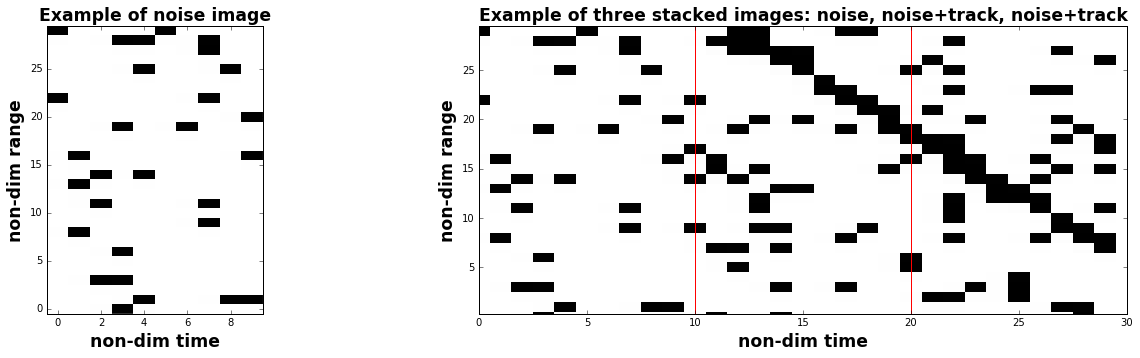

In [3]:
font0 = FontProperties();
font1 = font0.copy();
font1.set_size('xx-large');
font1.set_weight('bold');

fig = plt.figure(figsize=(30,20));
cmap = colors.ListedColormap(['white', 'black']);
#rect = l,b,w,h
rect1 = 0.2, 0.1, 0.1, 0.2
rect2 = 0.4, 0.1, 0.3, 0.2
start = 2*3 
ax1= fig.add_axes(rect1);
ax2 = fig.add_axes(rect2);
im = test_X[start,:,:].copy()
ax1.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
ax1.set_title('Example of noise image',fontproperties=font1);
ax1.set_xlabel('non-dim time',fontproperties=font1);
ax1.set_ylabel('non-dim range',fontproperties=font1);
ims = test_X[start:start+3,:,:].copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]));
ax2.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
ax2.set_title('Example of three stacked images: noise, noise+track, noise+track',fontproperties=font1);
ax2.set_xlabel('non-dim time',fontproperties=font1);
ax2.set_ylabel('non-dim range',fontproperties=font1);
ax2.set_xlim(0,30);
ax2.set_ylim(0.30);
for i in range(0,30,10):
    ax2.plot([i, i],[0, 30],'r-');


Above, the left image shows a typical distribution of noise marked by black rectangulas.  On the right, the three images have been concatenated. From the left to the right, the first image corresponds to noise shown on the left, and the next two images show a linear track, looking as a staircase consisting from small black rectangular boxes going down through the middle and the rightmost images.

For purposes of LSTM processing, in this work the images are processed in the sequences of ten. Below, I show only the first three to stress the 3D arrangement of data.

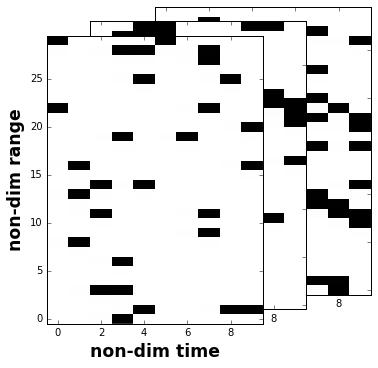

In [4]:
fig = plt.figure(figsize=(30,20));
cmap = colors.ListedColormap(['white', 'black']);
#rect = l,b,w,h
rect1 = 0.2, 0.1, 0.1, 0.2
rect2 = 0.22, 0.11, 0.1, 0.2
rect3 = 0.25, 0.12, 0.1, 0.2

ax1= fig.add_axes(rect3);
im = test_X[start+2,:,:].copy()
ax1.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
ax2= fig.add_axes(rect2);
im = test_X[start+1,:,:].copy()
ax2.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
ax3= fig.add_axes(rect1);
im = test_X[start,:,:].copy()
ax3.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
ax3.set_xlabel('non-dim time',fontproperties=font1);
ax3.set_ylabel('non-dim range',fontproperties=font1);

# Learning to detect tracks using Long Short-Time-Memory model

I use LSTM model architecture in Keras framework with the Tensorflow backend. Below, if ‘keras_model_load’ is set to True, the pre-trained model will be used. If ‘keras_model_load’ is set to False, the model is trained from scratch.

In [5]:
keras_model_load = True # False, True
batch_size = 3

if keras_model_load:
    model_name = 'keras_3k_dat_linmodel'
    model_lin = utils.load_keras_model(model_name)
else:
    np.random.seed(17)
    input_shape = (train_X.shape[1],train_X.shape[2])
    hidden_size = 16
    model_lin = Sequential()
    model_lin.add(LSTM(input_shape=input_shape, output_dim=hidden_size, return_sequences=True))
    model_lin.add(Dense(hidden_size))
    model_lin.add(Activation('relu'))
    model_lin.add(Dense(output_dim=1, activation="relu"))
    optimizer = optimizers.Adam(clipnorm=2)
    model_lin.compile(optimizer=optimizer, loss='binary_crossentropy')
    model_lin.summary()


Model loaded from file


In [6]:
if not keras_model_load:
    y3D = utils.track_y_3D(train_y_true, n = dxn)
    model_lin.fit(train_X, y3D, epochs = 100, batch_size = batch_size, verbose = 1, shuffle=True)

Now we use the trained model to predict labels of the input images used for training as well as for testing

In [7]:
Y_estim_train = model_lin.predict(train_X, batch_size = batch_size)
Y_estim_test = model_lin.predict(test_X, batch_size = batch_size)
print(Y_estim_train.shape, Y_estim_test.shape)

(3000, 10, 1) (300, 10, 1)


To estimate one label per image,  we need to average over 10 labels that were generated for 10 time steps of  each image.

In [8]:
Y_estim_train=Y_estim_train.sum(axis=1)/Y_estim_train.shape[1]
Y_estim_test=Y_estim_test.sum(axis=1)/Y_estim_test.shape[1]

Since the predicted output is real valued, using the threshold value of 0.5, I categorized the output into two categories: the ones corresponding to the track presence (y=1), and the ones corresponding to the track absence (y=0). Below y corresponds either to the Y_estim_test or to the Y_estim_train.

In [9]:
Y_estim_test[Y_estim_test < 0.5]=0
Y_estim_test[Y_estim_test >= 0.5]=1
Y_estim_train[Y_estim_train < 0.5]=0
Y_estim_train[Y_estim_train >= 0.5]=1

# Results

Below is shown a subset of the training and test results. On top of each concatenated image, the distribution of averaged labels is plotted. The blue and the red colors show respectively the true and the estimated labels. Note that both label types match perfectly for the training subset shown below. 

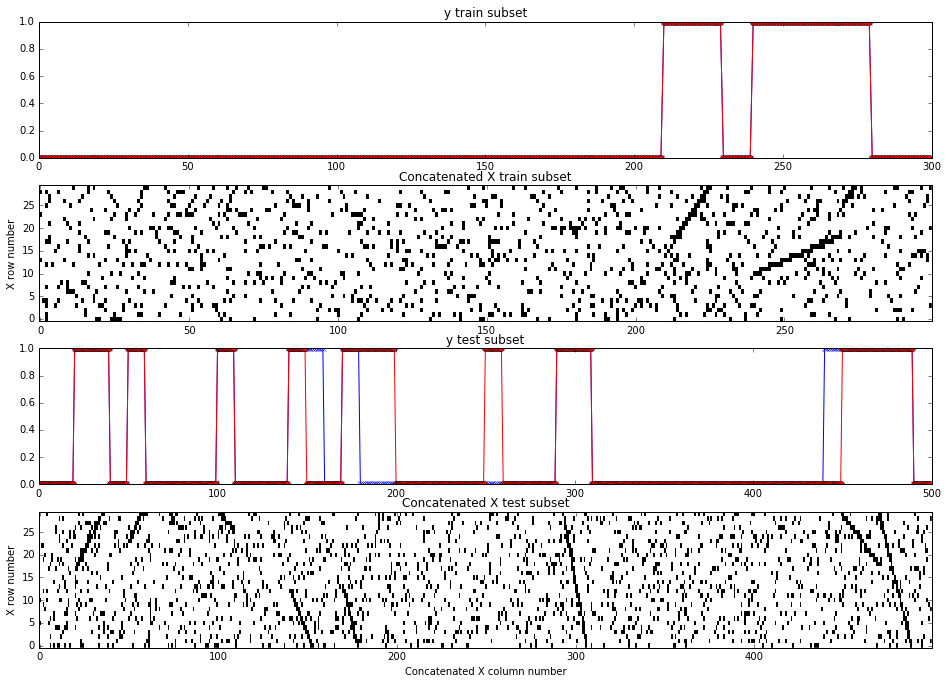

In [10]:
row1_train = 60
row2_train = 90
row1_test = 100
row2_test = 150
dxn = 10

utils.plot_results(test_y_true, Y_estim_test, train_X, train_y_true, Y_estim_train, test_X,
                 dxn, row1_train, row2_train, row1_test, row2_test, N_plots = 7)

Finally, I estimated the probability of detection (Pd) and the probability of false alarms (Pfa), applied to the test, and to the training data. This metrics is often used for [receiver operating characterisitc](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) estimation.

In [11]:
utils.roc_dat(Y_estim_test, test_y_true, 0.5)

Pd:  0.629 # of true positives:  70.0 # of estimated positives:  71.0
P_false_pos_rate:  0.117 # of true negatives:   230.0 # of estimated negatives:  229.0


In [12]:
utils.roc_dat(Y_estim_train, train_y_true, 0.5)

Pd:  0.988 # of true positives:  651.0 # of estimated positives:  649.0
P_false_pos_rate:  0.003 # of true negatives:   2349.0 # of estimated negatives:  2351.0
